## Day 10

https://adventofcode.com/2023/day/10

### Part 1

In [1]:
def readInput10(infile):
    with open(infile) as f:
        grid = [ l.strip('\n') for l in f.readlines() ]
        return grid

in_out = { "N": "S", "S": "N", "E": "W", "W": "E"}

pipes = {
    "|" : {"S": "N", "N": "S"},
    "-" : {"W": "E", "E": "W"},
    "L" : {"N": "E", "E": "N"},
    "J" : {"N": "W", "W": "N"},
    "7" : {"W": "S", "S": "W"},
    "F" : {"E": "S", "S": "E"},
    "S" : {"S": "N", "N": "S", "W": "E", "E": "W"}
}

moves = {
    "N": (0,-1),
    "S": (0,+1),
    "W": (-1,0),
    "E": (+1,0),
}

def findStart(grid):
    for j,l in enumerate(grid):
        for i,p in enumerate(l):
            if p=="S":
                return (i,j)

def mapGrid(grid):
    '''map connections on the pipe grid to ease navigation (who knows what would come in Part 2...)'''
    s = findStart(grid)
    gridmap = {}
    p = s
    while True:
        # stop mapping if both connections to S have been mapped
        if s in gridmap.keys():
            if sum([ cs in gridmap.keys() for cs in gridmap[s] ])==2:
                break
        x,y = p
        g = grid[y][x]
        conns = []
        for d in pipes[g].keys():
            dx,dy = moves[d]
            xn,yn = x+dx,y+dy
            if 0<=xn<len(grid[0]) and 0<=yn<len(grid):
                gn = grid[yn][xn]
                if gn != ".":
                    # check if pipe in neighbouring position has a corresponding entrance
                    i = in_out[d]
                    if i in pipes[gn].keys():
                        #print( i )
                        conns.append((xn,yn))
        gridmap[p] = conns
        # continue mapping in the direction not already mapped
        for c in conns:
            if c in gridmap.keys():
                continue
            p = c        
    return s, gridmap

def furthestCell(grid):
    '''
    Navigate pipe loop in both direction, stop when furthest cell reached. 
    Retuns half-loop steps (solution to Part 1) and loop coordinates.
    '''
    s, gridmap = mapGrid(grid) 
    path1 = [s]
    path2 = [s]
    p1 = gridmap[s][0]
    p2 = gridmap[s][1] 
    i1 = 1
    i2 = 1
    path1.append(p1)
    path2.append(p2)
    while True:
        for p in gridmap[p1]:
            if p in path1:
                continue
            p1 = p
            path1.append(p1)
            i1+=1
        for p in gridmap[p2]:
            if p in path2:
                continue
            p2 = p
            path2.append(p2)
            i2+=1
        if p1==p2:
            loop = path1+path2[::-1][1:-1]
            return i1,loop
            break
            
def part1(infile):
    grid = readInput10(infile)
    f, _ = furthestCell(grid)
    return f

In [2]:
print("Test 1:",part1("examples/example10.txt"))
print("Part 1:",part1("AOC2023inputs/input10.txt"))

Test 1: 8
Part 1: 6738


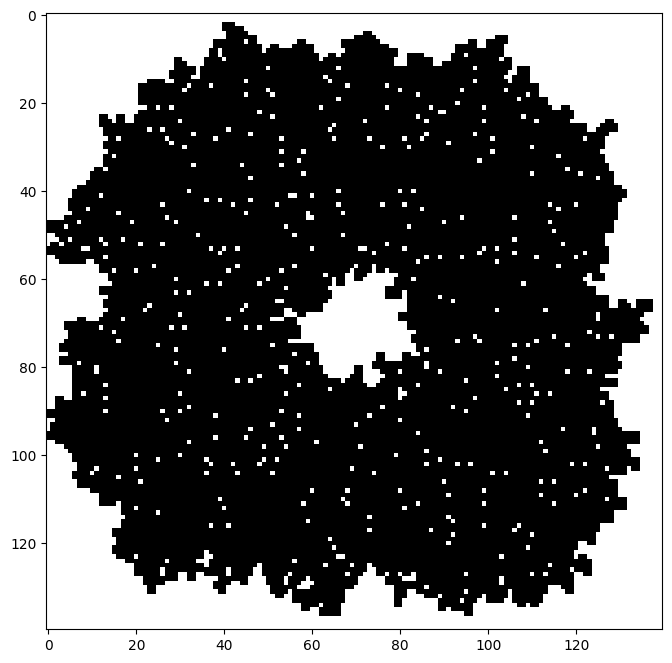

In [3]:
import matplotlib.pyplot as plt
import numpy as np

grid = readInput10("AOC2023inputs/input10.txt")
_, loop = furthestCell(grid)

pipemap = np.zeros((len(grid[0]),len(grid)),dtype=int)
for x,y in loop:
    pipemap[x][y] = 1
    
fig = plt.figure(figsize=(8,8), dpi=100)
_ = plt.imshow(pipemap,cmap="binary")

### Part 2

Strategy:
* Expand initial map replacing each pipe in the loop with a 3x3 tile with the pipe design
* Flood-fill the expanded map to visualize regions outside and inside the loop
* Contract the colored map again to the original size (keeping 3x3 tile center color) to count tiles within the loop

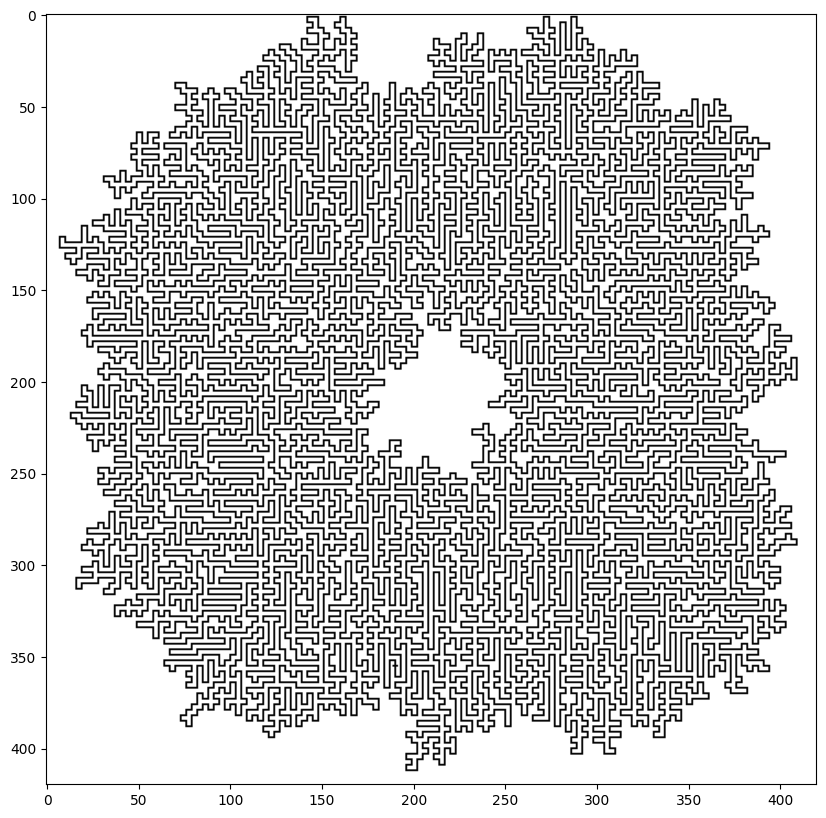

In [10]:
# expand the loop map with 3x3 tiles for the pipe elements

pipetiles = {
    "|" : [[0,1,0],[0,1,0],[0,1,0]],
    "-" : [[0,0,0],[1,1,1],[0,0,0]],
    "L" : [[0,1,0],[0,1,1],[0,0,0]],
    "J" : [[0,1,0],[1,1,0],[0,0,0]],
    "7" : [[0,0,0],[1,1,0],[0,1,0]],
    "F" : [[0,0,0],[0,1,1],[0,1,0]],
    "S" : [[0,1,0],[1,1,1],[0,1,0]],
}

gridexp = np.zeros((3*len(grid),3*len(grid[0])),dtype=int)

for x,y in loop:
    t = grid[y][x]
    gridexp[3*y:3*y+3,3*x:3*x+3] = pipetiles[t]

fig = plt.figure(figsize=(10,10), dpi=100)
_ = plt.imshow(gridexp,cmap="binary")

In [11]:
# Recursive flood fill algorithm

import sys
sys.setrecursionlimit(1_000_000)

def flood_fill_util(x, y, target_color, replacement_color, image):
    rows, cols = len(image), len(image[0])
    if x < 0 or x >= rows or y < 0 or y >= cols:
        return
    if image[x][y] != target_color:
        return
    image[x][y] = replacement_color
    flood_fill_util(x-1, y, target_color, replacement_color, image)
    flood_fill_util(x+1, y, target_color, replacement_color, image)
    flood_fill_util(x, y-1, target_color, replacement_color, image)
    flood_fill_util(x, y+1, target_color, replacement_color, image)

def flood_fill(x, y, replacement_color, image):
    target_color = image[x][y]
    if target_color != replacement_color:
        flood_fill_util(x, y, target_color, replacement_color, image)

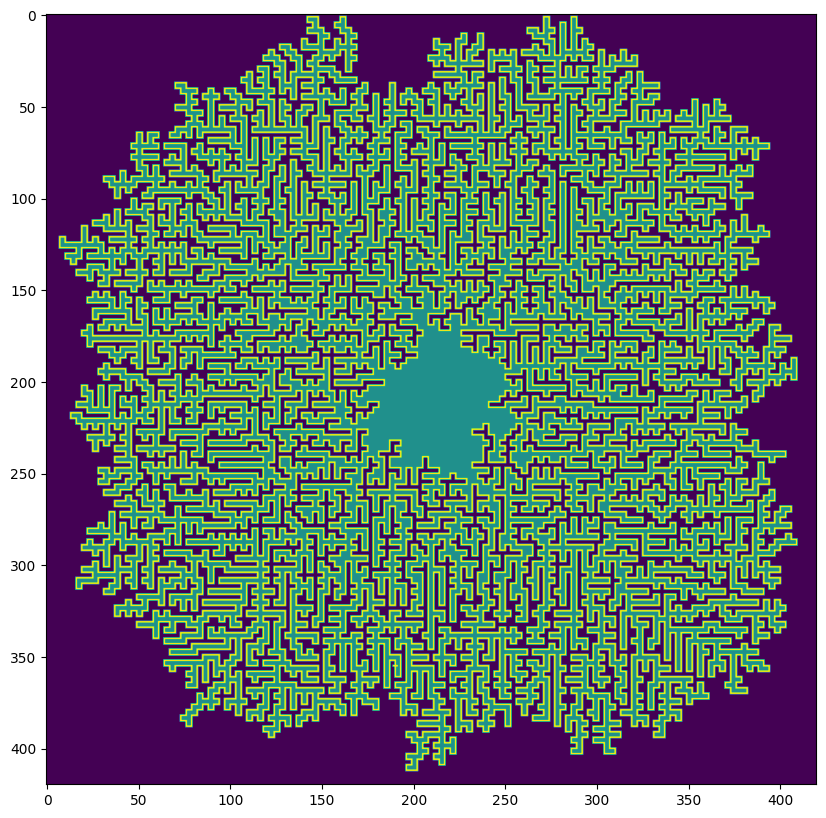

In [12]:
# Flood-fill the expanded map starting from (0,0)

flood_fill(0, 0, -1, gridexp)

fig = plt.figure(figsize=(10,10), dpi=100)
_ = plt.imshow(gridexp)

Part 2: 579


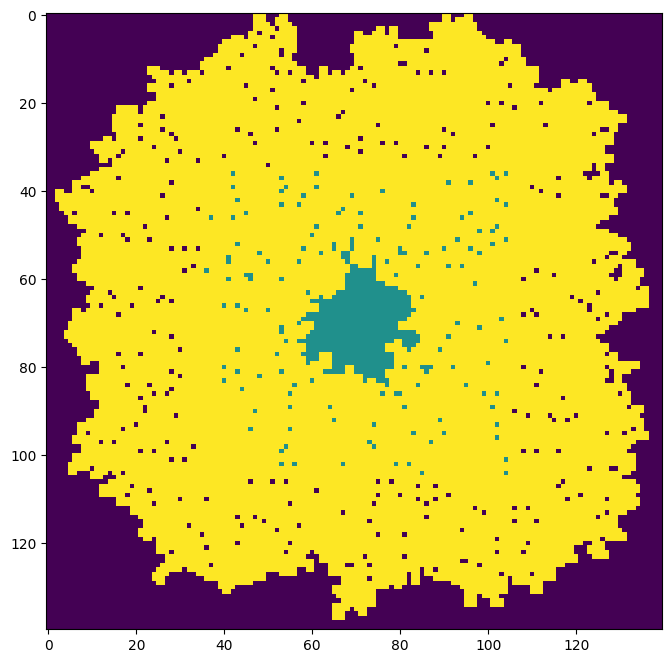

In [13]:
# Contract the flood-filled map to the original size, count the tiles within the loop

gridnew = np.zeros((len(grid),len(grid[0])),dtype=int)

for y in range(len(gridnew)):
    for x in range(len(gridnew[0])):
        xe = 3*x+1
        ye = 3*y+1
        gridnew[y,x] = gridexp[ye,xe]

fig = plt.figure(figsize=(8,8), dpi=100)
_ = plt.imshow(gridnew)

print("Part 2:",len(gridnew[gridnew==0]))